In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


=== 3.a: One Hidden Layer ===
Training Time: 0.1987 sec
Final Training Loss: 0.848689
Final Validation Loss: 1.448221
Validation R² Score: 0.1166

=== 3.b: Three Hidden Layers ===
Training Time: 0.3017 sec
Final Training Loss: 0.683093
Final Validation Loss: 1.192755
Validation R² Score: 0.2724


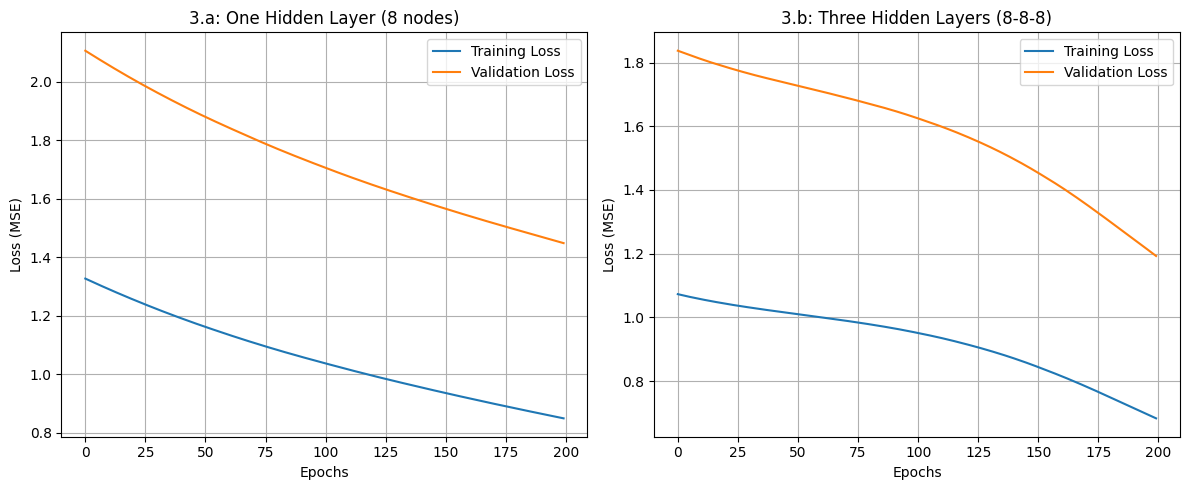

In [5]:
# === Problem 3: Neural Network Regression on Housing Dataset (with Graphs) ===
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# --- Load dataset from Google Drive ---
file_url = "/content/drive/MyDrive/Courses/ML/Housing.csv"
data = pd.read_csv(file_url)

# --- Select columns ---
features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
target = 'price'

X = data[features].values
y = data[target].values.reshape(-1, 1)

# --- 80/20 Train–Validation Split ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Normalize BOTH inputs and outputs ---
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X_train)
X_val   = X_scaler.transform(X_val)
y_train = y_scaler.fit_transform(y_train)
y_val   = y_scaler.transform(y_val)

# --- Convert to tensors ---
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32)

# --- Training Function (records loss each epoch) ---
def train_model(model, lr=0.0005, epochs=200):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        y_pred = model(X_train_t)
        loss = criterion(y_pred, y_train_t)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate validation loss each epoch
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_loss = criterion(val_pred, y_val_t).item()
        train_losses.append(loss.item())
        val_losses.append(val_loss)

    training_time = time.time() - start_time

    # Compute R² in original scale
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_t)
        val_pred_inv = y_scaler.inverse_transform(val_pred.numpy())
        y_val_inv = y_scaler.inverse_transform(y_val)
        r2 = r2_score(y_val_inv, val_pred_inv)

    return training_time, train_losses, val_losses, r2

# === 3.a: One Hidden Layer ===
class Net_1Hidden(nn.Module):
    def __init__(self):
        super(Net_1Hidden, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.net(x)

model1 = Net_1Hidden()
t1, train_loss1, val_loss1, r2_1 = train_model(model1)

print("=== 3.a: One Hidden Layer ===")
print(f"Training Time: {t1:.4f} sec")
print(f"Final Training Loss: {train_loss1[-1]:.6f}")
print(f"Final Validation Loss: {val_loss1[-1]:.6f}")
print(f"Validation R² Score: {r2_1:.4f}")

# === 3.b: Three Hidden Layers ===
class Net_3Hidden(nn.Module):
    def __init__(self):
        super(Net_3Hidden, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.net(x)

model3 = Net_3Hidden()
t3, train_loss3, val_loss3, r2_3 = train_model(model3)

print("\n=== 3.b: Three Hidden Layers ===")
print(f"Training Time: {t3:.4f} sec")
print(f"Final Training Loss: {train_loss3[-1]:.6f}")
print(f"Final Validation Loss: {val_loss3[-1]:.6f}")
print(f"Validation R² Score: {r2_3:.4f}")

# --- Plot Training & Validation Loss for both models ---
plt.figure(figsize=(12, 5))

# One hidden layer
plt.subplot(1, 2, 1)
plt.plot(train_loss1, label="Training Loss")
plt.plot(val_loss1, label="Validation Loss")
plt.title("3.a: One Hidden Layer (8 nodes)")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)

# Three hidden layers
plt.subplot(1, 2, 2)
plt.plot(train_loss3, label="Training Loss")
plt.plot(val_loss3, label="Validation Loss")
plt.title("3.b: Three Hidden Layers (8-8-8)")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


